In [1]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
from SimPEG.utils.code_utils import validate_ndarray_with_shape
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

class plot_mref(directives.InversionDirective):

    mesh = None
    
    def initialize(self):
        self.start = 0
        # self.endIter()
    
    def endIter(self):
        # plot
        meshCore = self.mesh
        # predicted = self.invProb.reg.gmmref.predict(self.opt.xc.reshape(-1, 1))
        fig,ax = plt.subplots(3,1,figsize=(15,5))
        mm = meshCore.plot_image(
            self.opt.xc, ax=ax[0],
            # clim=[-np.log(250),-np.log(10),],
            # clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        mm2 = meshCore.plot_image(
            1 / np.exp(self.invProb.reg.objfcts[0].reference_model), ax=ax[1],
            # clim=[-np.log(250),-np.log(10),],
            clim=[0,500],
            pcolor_opts={'cmap':'Spectral'}
        )
        # ax.set_xlim([-750,750])
        # ax.set_ylim([-250,0])
        # fig,ax = plt.subplots(1,1,figsize=(15,5))
        # mmpred = meshCore.plot_image(
        #    predicted, ax=ax[3],
        #     # clim=[-np.log(250),-np.log(10),],
        #     pcolor_opts={'cmap':'Spectral'}
        # )
        
        #plt.colorbar(mm[0])
        # utils.plot2Ddata(
        #     meshCore.gridCC,1 / np.exp(mtrue[actcore]),nx=500,ny=500,
        #     contourOpts={'alpha':0},
        #     clim=[0,500],
        #     ax=ax[0],
        #     level=True,
        #     ncontour=2,
        #     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        #     method='nearest'
        # )

        ax[2].hist(1 / np.exp(self.opt.xc), 100)
        # ax[2].set_aspect(1)

        # ax[0].set_ylim([-15,0])
        # ax[0].set_xlim([-15,15])
        ax[0].set_aspect(1)
        # ax[1].set_ylim([-15,0])
        # ax[1].set_xlim([-15,15])
        ax[1].set_aspect(1)
        fig.savefig(f'./iterations/{self.start}.png')
        np.save(f'./iterations/model_{self.start}.npy', self.opt.xc)
        plt.show()
        self.start += 1


# update the neighbors
class segment_iter(directives.InversionDirective):

    seg_iter = 2
    segmentation_model: geoseg.SamClassificationModel=None
    method = 'bound_box'
    reg_rots = np.zeros(0)
    
    def initialize(self):
        self.count = 0
    
    def endIter(self):

        print(f"Segmenting-iteration: {self.opt.iter}")
        if self.count == self.seg_iter:
            
            # self.reg[1][1].update_gradients(self.opt.xc)
            masks = self.segmentation_model.fit(self.opt.xc)

            mesh = self.segmentation_model.mesh
            reg_dirs = [np.identity(2) for _ in range(mesh.nC)]
            sqrt2 = np.sqrt(2)
            reg_rots = np.zeros(mesh.nC)

            # loop through masks and assign rotations
            for ii in range(1, len(masks) - 2):
                seg_data = masks[ii]['segmentation']
                seg_data = np.flip(seg_data)
                # Find the coordinates of the object pixels
                object_pixels = np.argwhere(seg_data == 1)

                # Apply PPCA to determine orientation
                if len(object_pixels) > 1:
                    # Standardize the data
                    scaler = StandardScaler()
                    object_pixels_std = scaler.fit_transform(object_pixels)

                    # Apply PPCA
                    pca = PCA(n_components=2)
                    pca.fit(object_pixels_std)

                    # The first principal component (eigenvector) will represent the orientation
                    orientation_vector = pca.components_[0]

                    # Compute the angle of the orientation vector (in degrees)
                    angle_degrees = np.arctan2(orientation_vector[1], orientation_vector[0]) * 180 / np.pi

                    print(f"Orientation angle (degrees): {angle_degrees}")
                    angle_radians = angle_degrees * np.pi / 180

                    # Create the 2x2 rotation matrix
                    # rotation_matrix = np.array([
                    #     [np.cos(angle_radians), -np.sin(angle_radians)],
                    #     [np.sin(angle_radians), np.cos(angle_radians)]
                    # ])
                    
                    rotation_matrix = 1 / np.array([[sqrt2, -sqrt2], [-sqrt2, -sqrt2],])
                    alphas = np.ones((mesh.n_cells, mesh.dim))
                    # check for rotation application method
                    if self.method == 'bound_box':
                        bbox_mask = self.segmentation_model.get_bound_box_indicies(ii)

                        flatten = bbox_mask # masks[ii]['segmentation'].flatten(order='F')
                        reshape = flatten.reshape(mesh.shape_cells, order='F')

                        plt.imshow(reshape.T)
                        plt.title(f'mask: {ii + 1}')
                        plt.gca().invert_yaxis()
                        # plt.plot([x0, x1], [y0, y1], 'ok')
                        plt.show()

                        for ii in range(mesh.nC):

                            if bbox_mask[ii] == 1:
                                print('adjusting')
                                # reg_cell_dirs[ii] = np.array([[cos, -sin], [sin, cos],])
                                reg_dirs[ii] = rotation_matrix
                                alphas[ii] = [25, 150]
                                reg_rots[ii] = angle_degrees
                        #         alphas[ii] = [150, 25]
                        # reg_dirs[bbox_mask] = [rotation_matrix] * int(bbox_mask.sum())
                    else:
                        reg_dirs[seg_data] = [rotation_matrix] * seg_data.sum()

                    reg_dirs = validate_ndarray_with_shape(
                        "reg_dirs",
                        reg_dirs,
                        shape=[(mesh.dim, mesh.dim), ("*", mesh.dim, mesh.dim)],
                        dtype=float,
                    )
                    
                    reg_seg = geoseg.GeologicalSegmentation(

                        mesh, 
                        reg_dirs=reg_dirs,
                        alphas=alphas,
                        ortho_check=False,

                    )

                    reg_small = regularization.Smallness(
                        mesh=mesh,
                        reference_model=self.reg[0][1].reference_model,
                        )


                    self.reg = reg_small + reg_seg
                    self.reg.multipliers = np.r_[1e-5, 1000.0]
                    self.invProb.reg = self.reg
                    self.reg_rots = reg_rots

                else:
                    raise ValueError("Not enough object pixels to determine orientation.")


        
        self.count += 1


3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


In [5]:
# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 12.5,  12.5,  12.5
# Number of core cells in each direction
ncx,  ncz = 82,  31
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -175)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -100)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
# fig,ax = plt.subplots(3, 1,figsize=(10,20))
# mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

# ax[0].set_xlim([-1000,1000])
# ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

index_deeper = mesh.gridCC[:, 1] < -200

res_true[index_deep] = 500
res_true[index_deeper] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -1000., 1000.
ymin, ymax = -500., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.extract_core_mesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
# mm = meshCore.plot_image(
    
#     1/(cond_true)[actcore],
#     ax=ax[0],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# utils.plot2Ddata(

#     meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
#     contourOpts={'alpha':0},
#     #clim=[0,5],
#     ax=ax[0],
#     level=True,
#     ncontour=2,
#     levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
#     method='nearest'
    
# )
#plt.gca().set_ylim([-200,0])
# ax[0].set_aspect(1)
# plt.colorbar(mm[0], label=r'$\Omega$ m')
# ax[0].set_title('True model')

xmin, xmax = -750., 750.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.arange(25,250,25):

    print(f'adding dipole size: {dipole}')
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.01
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=4e-3,
    force=True,
    add_noise=True,

)

# dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.1)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())


# uhat = steepest_descent(simulation.Jtvec, dc_data.dobs, 20)

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# meshCore.plot_image(uhat, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
# plt.show()

# -----------------------------------------------------------------------

# dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)


  TensorMesh: 4,558 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    106     -5,340.49      5,340.49     12.50  1,621.83    1.50
   y     43     -5,209.24          6.25     12.50  1,621.83    1.50


adding dipole size: 25
adding dipole size: 50
adding dipole size: 75
adding dipole size: 100
adding dipole size: 125
adding dipole size: 150
adding dipole size: 175
adding dipole size: 200
adding dipole size: 225
0.010819118290503886
1464.0645787267138


In [6]:
np.quantile(np.abs(dc_data.dobs), 0.08)

0.0029629483718054935

/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/directives/directives.py:335: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  [directive.validate(self) for directive in self.dList]



                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/directives/directives.py:332: UserWarning: There is no PGI regularization. Smallness target is turned off (TriggerSmall flag).
  getattr(r, ruleType)()


model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-01  3.91e+04  0.00e+00  3.91e+04    6.79e+03      0              
geophys. misfits: 8332.3 (target 3164.0 [False])


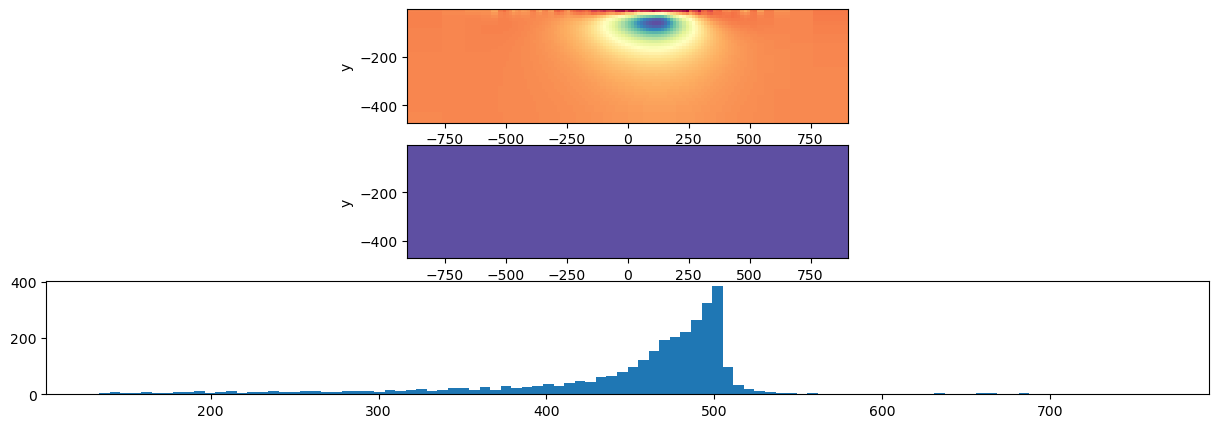

   1  5.00e-02  8.33e+03  3.71e+04  1.02e+04    8.58e+02      0              
geophys. misfits: 5966.2 (target 3164.0 [False])


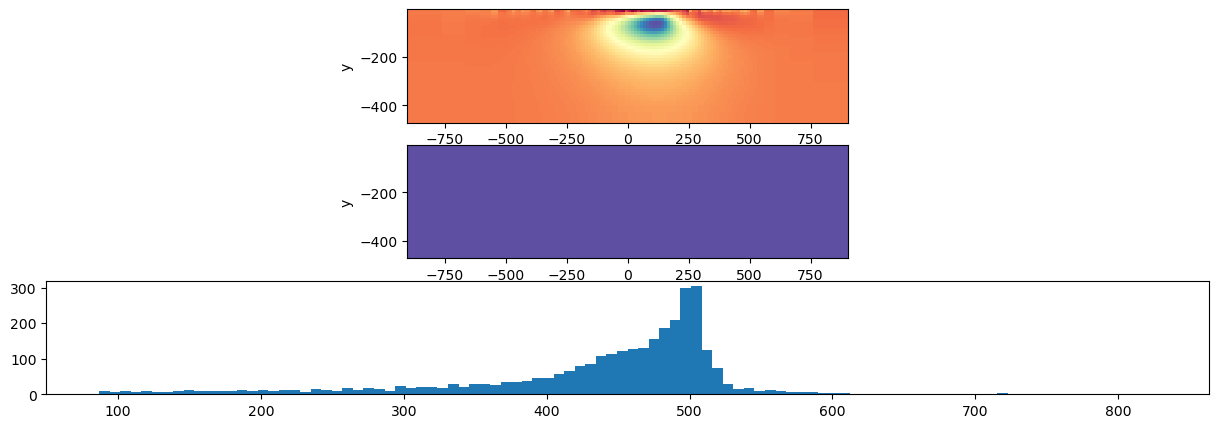

   2  2.50e-02  5.97e+03  6.24e+04  7.53e+03    2.52e+02      0   Skip BFGS  
geophys. misfits: 4760.2 (target 3164.0 [False])


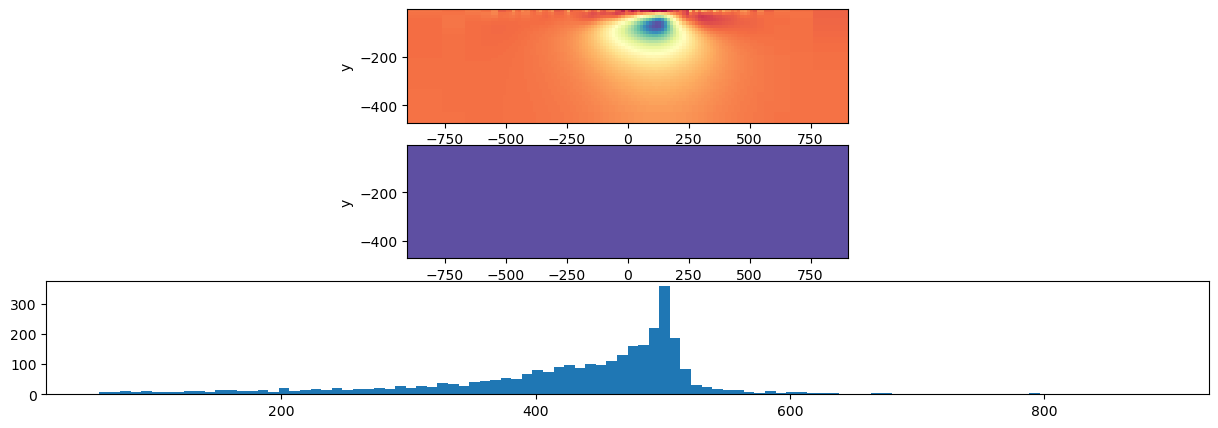

   3  1.25e-02  4.76e+03  9.19e+04  5.91e+03    2.22e+02      0   Skip BFGS  
geophys. misfits: 4085.3 (target 3164.0 [False])


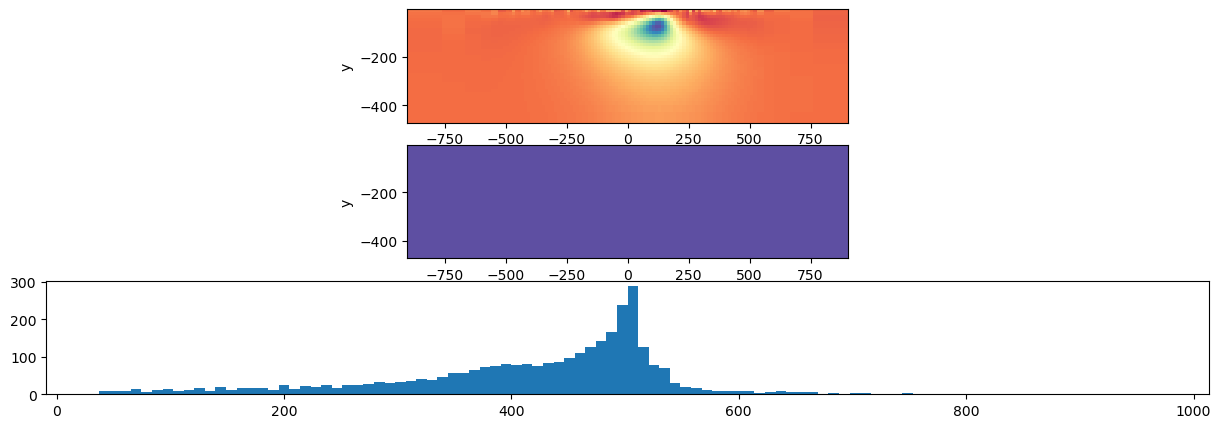

   4  6.25e-03  4.09e+03  1.22e+05  4.85e+03    2.41e+02      0   Skip BFGS  
geophys. misfits: 3863.7 (target 3164.0 [False])


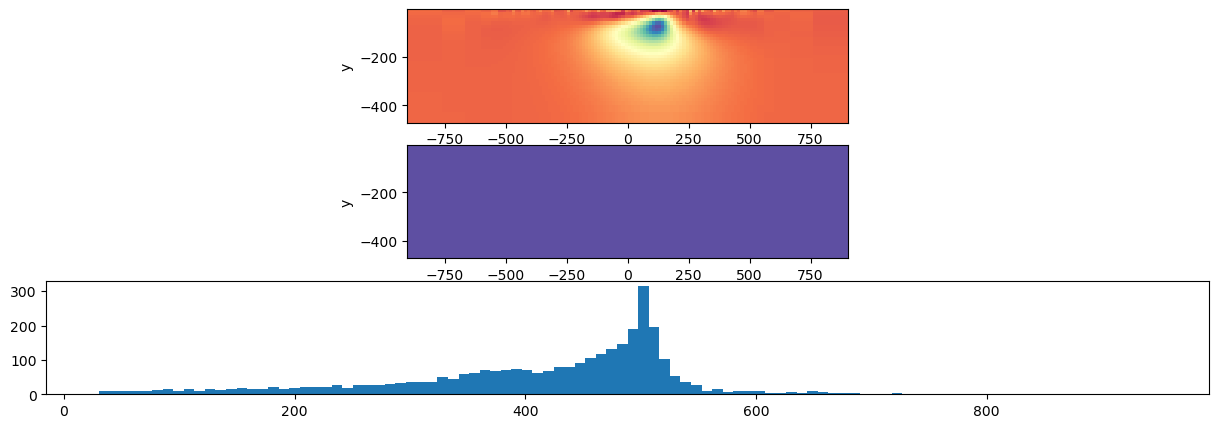

   5  1.56e-03  3.86e+03  1.36e+05  4.08e+03    2.38e+02      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 3.548436947860658
geophys. misfits: 3438.4 (target 3164.0 [False])


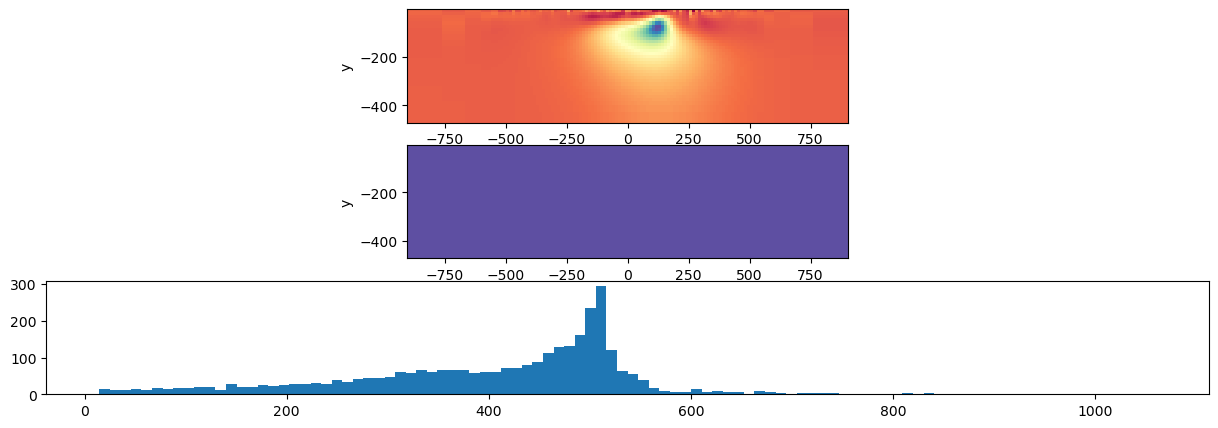

   6  7.81e-04  3.44e+03  2.62e+05  3.64e+03    2.28e+02      0              
geophys. misfits: 3354.4 (target 3164.0 [False])


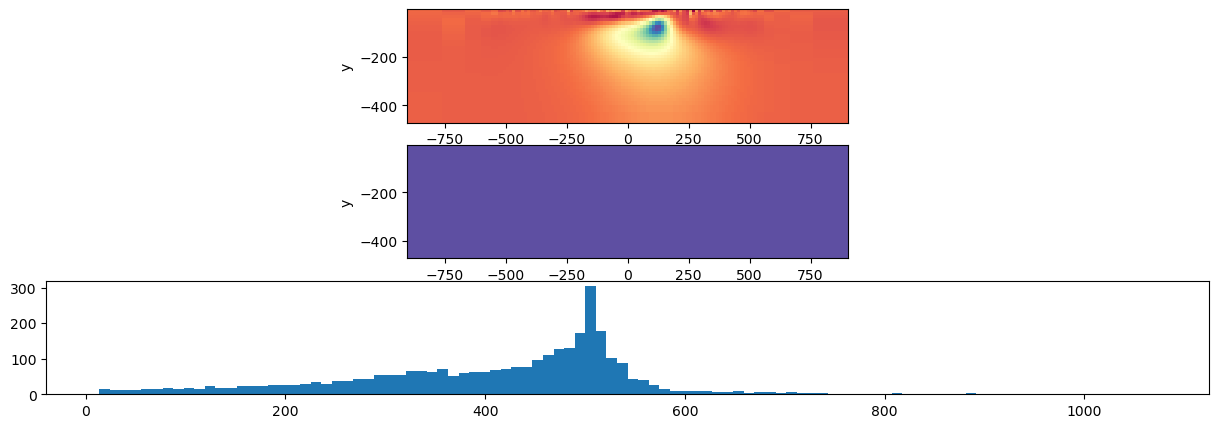

   7  7.81e-04  3.35e+03  2.87e+05  3.58e+03    1.09e+02      0              
geophys. misfits: 3289.1 (target 3164.0 [False])


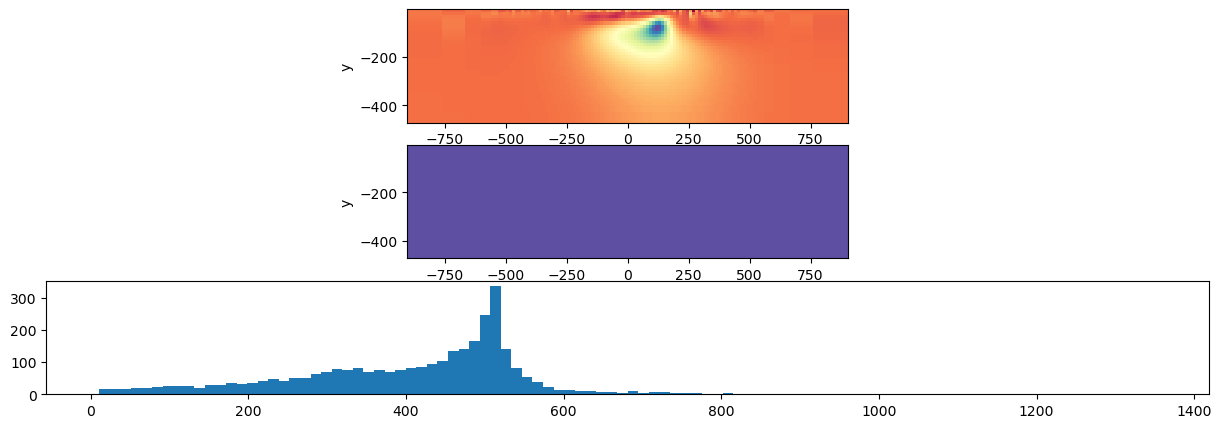

   8  7.81e-04  3.29e+03  3.49e+05  3.56e+03    1.47e+02      0              
geophys. misfits: 3241.2 (target 3164.0 [False])


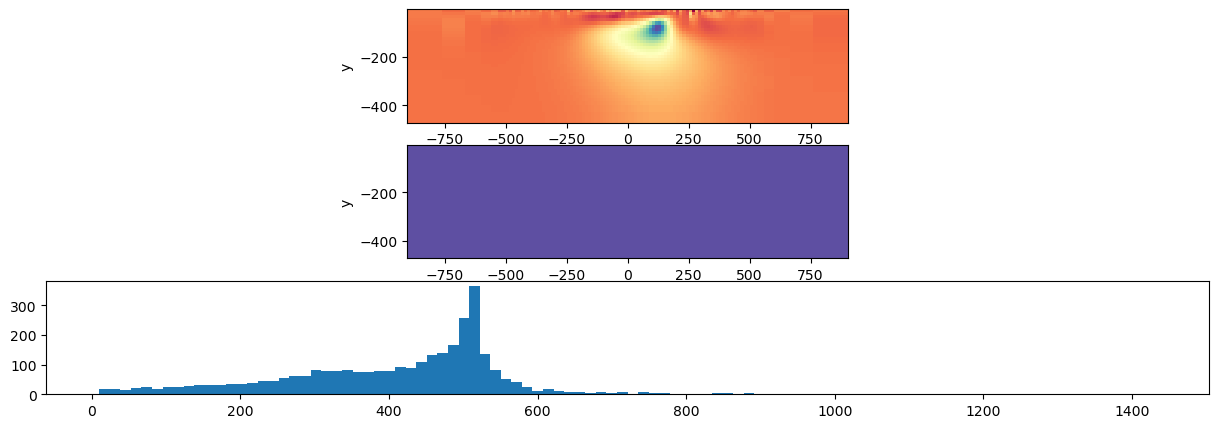

   9  7.81e-04  3.24e+03  3.82e+05  3.54e+03    1.34e+02      0              
geophys. misfits: 3195.5 (target 3164.0 [False])


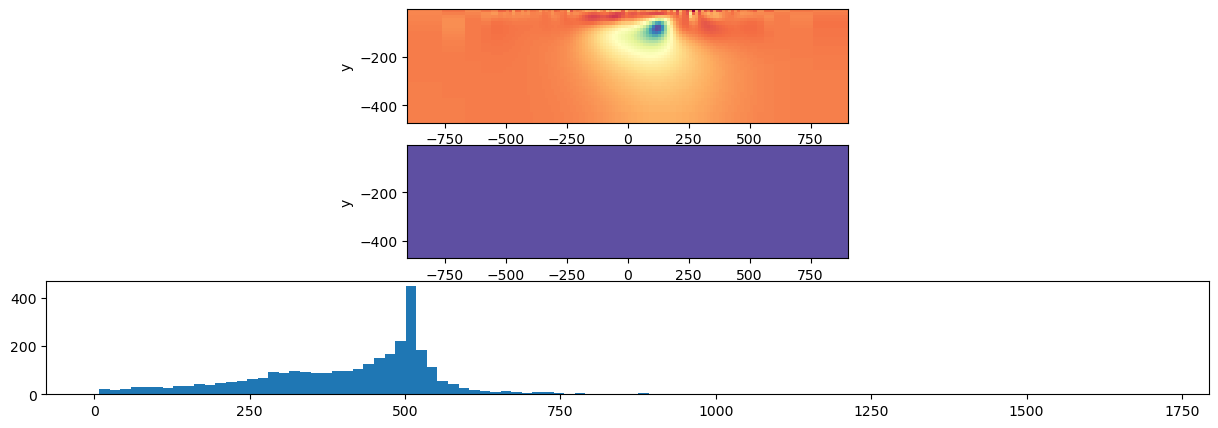

  10  3.91e-04  3.20e+03  4.50e+05  3.37e+03    8.19e+01      0              
geophys. misfits: 3170.9 (target 3164.0 [False])


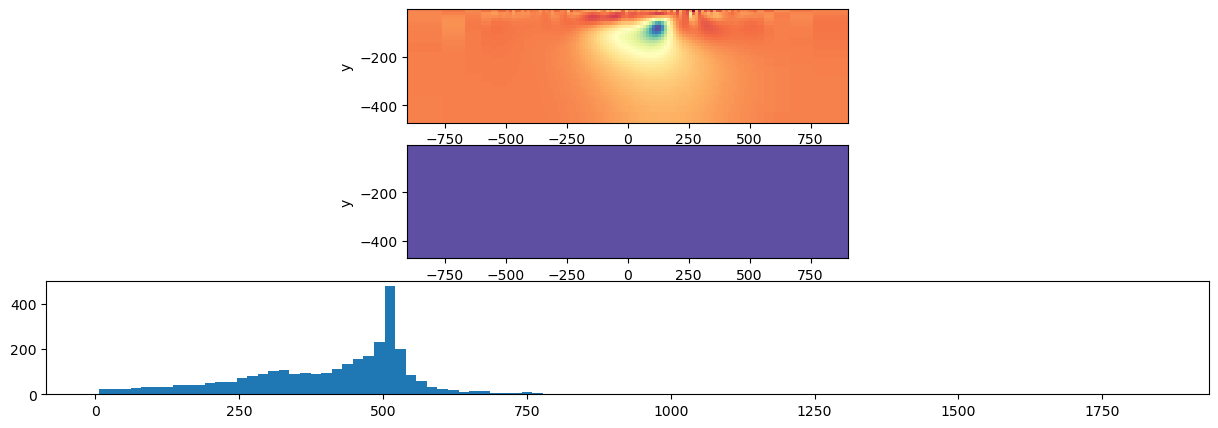

  11  3.91e-04  3.17e+03  5.12e+05  3.37e+03    9.19e+01      0              
geophys. misfits: 3157.1 (target 3164.0 [True])
All targets have been reached


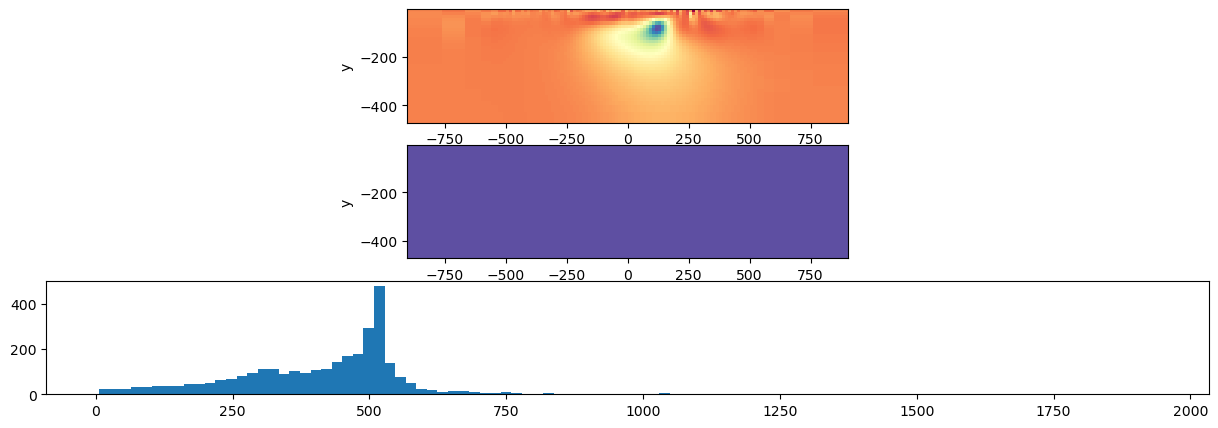

------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.9083e+03
1 : |xc-x_last| = 6.1435e-01 <= tolX*(1+|x0|) = 3.4713e+01
0 : |proj(x-g)-x|    = 9.1906e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 9.1906e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      30    <= iter          =     12
------------------------- DONE! -------------------------


In [8]:
# --------------------------------------------------------------------------

# setup the inversion

#

dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)
# dmis.w = 1 / np.abs(dc_data.dobs * 0.05 + np.quantile(np.abs(dc_data.dobs), 0.1))
# m0 = np.log(1/dcutils.apparent_resistivity_from_voltage(survey, dc_data.dobs).mean()) * np.ones(mapping.nP)
# m0 = np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/guided/model_11.npy")
m0 = np.log(1/500) * np.ones(mapping.nP)
# Create the regularization with GMM information
idenMap = maps.IdentityMap(nP=m0.shape[0])
wires = maps.Wires(('m', m0.shape[0]))

reg_mean = regularization.Sparse(
    mesh, 
    active_cells=actcore,
    norms=[1, 1 ,1],
    mapping=idenMap,
    reference_model=m0
)

reg_mean.reference_model_in_smooth = True  # Include reference model in smoothness

p = 1
qx = 1
qz = 1
reg_mean.norms = [p, qx, qz]

# Reach target misfit for L2 solution, then use IRLS until model stops changing.
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=25, minGNiter=1, chifact_start=1.2
)


# Optimization
opt = optimization.ProjectedGNCG(maxIter=30, upper=np.inf, lower=-np.inf, tolCG=1E-5, maxIterLS=20, )
opt.remember('xc')

# Set the inverse problem
invProb = inverse_problem.BaseInvProblem(dmis,  reg_mean,  opt)
betaIt = directives.BetaSchedule(coolingFactor=2, coolingRate=5)
targets = directives.MultiTargetMisfits(
    TriggerSmall=True,
    TriggerTheta=False,
    verbose=True,
)
# MrefInSmooth = directives.PGI_AddMrefInSmooth(verbose=True,  wait_till_stable=True, tolerance=0.0)

plot_iter_mref = plot_mref()
plot_iter_mref.mesh = meshCore
# updateSensW = directives.UpdateSensitivityWeights(threshold=5e-4, everyIter=False)
# update_Jacobi = directives.UpdatePreconditioner()
# save_pgi = SavePGIOutput('./pgi_param')
invProb.beta = 1e-1
inv = inversion.BaseInversion(invProb,
                            directiveList=[
                                            # updateSensW,
                                            # update_sam,
                                            #  petrodir,
                                            update_IRLS,
                                            targets, betaIt,
                                            # MrefInSmooth,
                                            plot_iter_mref,
                                            #  save_pgi,
                                            # update_Jacobi,
                                            ])

# Run!

mcluster = inv.run(m0)

# np.save("rotated_model_dip.npy", mcluster)
# np.save("true_model_dip.npy", mtrue)
# # mcluster = np.load("rotated_model.npy")


/tmp/ipykernel_187344/2290471302.py:8: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  d = meshCore.plotImage(1 / dip_model2, clim=[10, 500], ax=ax[0], pcolorOpts={'cmap':"Spectral"})


(array([1.500e+01, 1.000e+01, 3.000e+00, 5.000e+00, 1.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 6.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 4.000e+00,
        1.000e+00, 1.000e+00, 7.000e+00, 1.000e+00, 3.000e+00, 5.000e+00,
        4.000e+00, 8.000e+00, 8.000e+00, 1.300e+01, 1.800e+01, 1.300e+01,
        2.800e+01, 5.000e+01, 8.900e+01, 1.280e+02, 2.220e+02, 1.567e+03,
        7.540e+02, 3.800e+01, 1.800e+01, 1.300e+01, 3.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

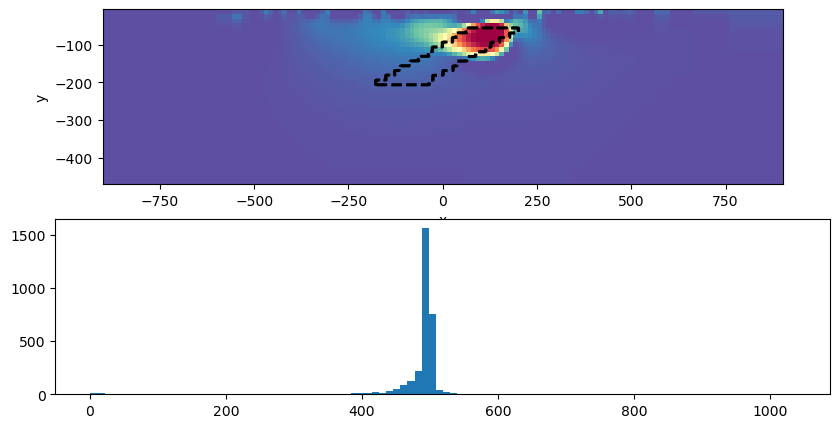

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

dip_model2 =  np.exp(np.load(r"/home/juanito/Documents/git/jresearch/geological_segmentation/iterations/model_7.npy"))

# conductivity_model_log10_l01 = np.log10(np.exp(np.log(dip_model2)))
# conductivity_model_log10_true = np.log10(np.exp(mtrue))
# clim = [conductivity_model_log10_true.min(), conductivity_model_log10_true.max()]
d = meshCore.plotImage(1 / dip_model2, clim=[10, 500], ax=ax[0], pcolorOpts={'cmap':"Spectral"})
# plt.colorbar(d[0], cmap='Spectral_r', label=r'conductivity (S/m)', ticks=[clim[0],clim[1]], format="$10^{%.1f}$", shrink=0.9).ax.tick_params(labelsize=14)

utils.plot2Ddata(

        meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
        contourOpts={'alpha':0},
        #clim=[0,5],
        ax=ax[0],
        level=True,
        ncontour=2,
        levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
        method='nearest'
        
    )

ax[1].hist(1 / dip_model2, 100)

In [ ]:
# dip_model = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/guided/model_11.npy"))
dip_model2 =  np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_14.npy"))
# dip_model3 = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/L2/model_10.npy"))
dip_model = np.exp(np.load(r"/home/juanito/git/jresearch/geological_segmentation/iterations/model_4.npy"))

fig, ax = plt.subplots(3,1, figsize=(15,15))
clim = [1 / 1000, 1/200]
# mm2 = utils.plot2Ddata(

#     meshCore.gridCC, dip_model3,nx=500,ny=500,
#     contourOpts={'cmap':"Spectral_r", 'alpha':1},
#     ax=ax[2],
#     level=True,
#     ncontour=8,
#     shade=True,
#     levelOpts={'colors':'k','linewidths':0.25},
#     method='linear',
#     # clim=clim,
#     shade_ncontour=100,
#     shade_azimuth=315.0,
#     shade_angle_altitude=45.0,
    
# )
# plt.colorbar(mm2[0], label=r'$\sigma$')

mm = utils.plot2Ddata(

    meshCore.gridCC, dip_model,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[0],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm[0], label=r'$\sigma$')

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[1],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[2],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

utils.plot2Ddata(

    meshCore.gridCC,cond_true[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)

mm1 = utils.plot2Ddata(

    meshCore.gridCC, dip_model2,nx=500,ny=500,
    contourOpts={'cmap':"Spectral_r", 'alpha':1},
    ax=ax[1],
    level=True,
    ncontour=8,
    shade=True,
    levelOpts={'colors':'k','linewidths':0.25},
    method='linear',
    # clim=clim,
    shade_ncontour=100,
    shade_azimuth=315.0,
    shade_angle_altitude=45.0,
    
)
plt.colorbar(mm1[0], label=r'$\sigma$')



# plt.colorbar(mm[0], label=r'$\Omega$ m')
plt.show()

# fig, ax = plt.subplots(1,1)
# mm = meshCore.plot_image(
    
#     # reg_mean.deriv(dip_model),
#     reg_1storder._anis_alpha[:, 0],
#     ax=ax,
#     # clim=[-0.08, 0.08],
#     pcolorOpts={'cmap':'Spectral_r'}

# )

# plt.colorbar(mm[0], label=r'$\Omega$ m')
# plt.show()

# print(reg_org(dip_model))
# print(reg_mean(dip_model))

# plt.hist(dip_model2)
plt.hist(dip_model)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/juanito/git/jresearch/geological_segmentation/iterations/model_14.npy'